In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as  plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Reshape

In [83]:
data = pd.read_csv("../../data/csv_files/at200.csv")

In [85]:
data.shape

(104852, 22)

In [87]:
data.head()

,Date Time,Actual Conductivity (ÂµS/cm),Specific Conductivity (ÂµS/cm),Salinity (psu),Resistivity (â„¦-cm),Density (g/cmÂ³),Total Dissolved Solids (mg/L),pH (pH),pH MV (mV),ORP (mV),...,Partial Pressure Oâ‚‚ (psi),Temperature (C),External Voltage (V),Pressure (psi),Depth (m),Level: Depth to Water (m),station_id,Level: Elevation (m),easting,northing
0,2023-01-11 14:34:00.000,161.135101,169.814270,0.089782,6205.972656,0.998789,110.379279,6.345863,33.323765,242.252640,...,1.728853,17.324095,15.786,1.576587,1.299949,2.264972,FPZ_04A,NaN,1383303.353,3875869.513
1,2023-01-11 14:39:00.000,161.549484,169.920212,0.089823,6190.053711,0.998772,110.448137,6.392928,30.763149,241.012863,...,1.653776,17.420801,15.813,1.575842,1.299401,2.177014,FPZ_04A,NaN,1383303.353,3875869.513
2,2023-01-12 00:00:00.000,160.563217,167.590134,0.088505,6228.076660,0.998702,108.933590,6.545794,22.439957,233.128357,...,1.121557,17.804754,15.777,1.577938,1.300915,2.175540,FPZ_04A,NaN,1383303.353,3875869.513
3,2023-01-13 00:00:00.000,160.465378,167.549561,0.088486,6231.874023,0.998705,108.907215,6.533609,23.105145,233.137894,...,1.053462,17.786329,15.804,1.586493,1.306872,2.169526,FPZ_04A,NaN,1383303.353,3875869.513
4,2023-01-14 00:00:00.000,160.041122,167.145935,0.088271,6248.394043,0.998707,108.644858,6.524963,23.577213,230.408005,...,1.064563,17.774521,15.786,1.592077,1.310799,2.165600,FPZ_04A,NaN,1383303.353,3875869.513


In [89]:
del(data["Level: Elevation (m)"])

In [91]:
station_data = data[data['station_id'] == "FSB_097D"]
station_data.shape

(9211, 21)

In [93]:
station_data = station_data.dropna()
station_data = station_data[1:]
station_data.shape

(3110, 21)

In [95]:
date_time = station_data["Date Time"]
input_data = station_data.drop(columns = ["pH (pH)", "Date Time", "station_id"])
output_data = station_data["pH (pH)"].values.reshape(-1,1)


input_scaler = StandardScaler()
output_scaler = StandardScaler()

scaled_input = input_scaler.fit_transform(input_data)
scaled_output = output_scaler.fit_transform(output_data)

scaled_input.shape, scaled_output.shape

((3110, 18), (3110, 1))

In [97]:
def create_3d_arrays_from_2d(array1, array2, overlap, window_size=10 ):
    def create_3d_array(array, window_size, overlap):
        step = window_size - overlap
        num_rows, num_columns = array.shape
        num_windows = (num_rows - window_size) // step + 1

        array_3d = np.zeros((num_windows, window_size, num_columns))
        
        count = 0
        for i in range(0, num_windows, step):
            array_3d[count] = array[i:i+window_size]
            count += 1
        
        return array_3d

    array1_3d = create_3d_array(array1, window_size, overlap)
    array2_3d = create_3d_array(array2, window_size, overlap)

    return array1_3d, array2_3d

In [99]:
X_train, Y_train = create_3d_arrays_from_2d(scaled_input, scaled_output, 6)

In [101]:
X_train.shape, Y_train.shape

((776, 10, 18), (776, 10, 1))

In [103]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(10, 18)),
    MaxPooling1D(pool_size=2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),    
    Dense(64, activation='relu'),
    Dense(10, activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error') 

/Users/sandeshgnawali/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
model.fit(X_train, Y_train, epochs = 100, batch_size = 64)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.3255
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 0.0634
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0241
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.0143
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0067
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.0050
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.0040
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.0042
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - loss: 0.0040
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 0.0039
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0027
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.0031
Epoch 13/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0026
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0032
Epoch 15/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [107]:
X_test, Y_test = create_3d_arrays_from_2d(scaled_input, scaled_output, 0)
X_test.shape, Y_test.shape

((311, 10, 18), (311, 10, 1))

In [127]:
model.evaluate(X_test, Y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 3.4766e-04


0.00012970440729986876

In [133]:
Y_pred = model.predict(X_test)
Y_pred.shape



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


(311, 10)

In [144]:
y_pred = Y_pred.flatten()
y_test = Y_test.flatten()

y_pred.shape, y_test.shape

((3110,), (3110,))

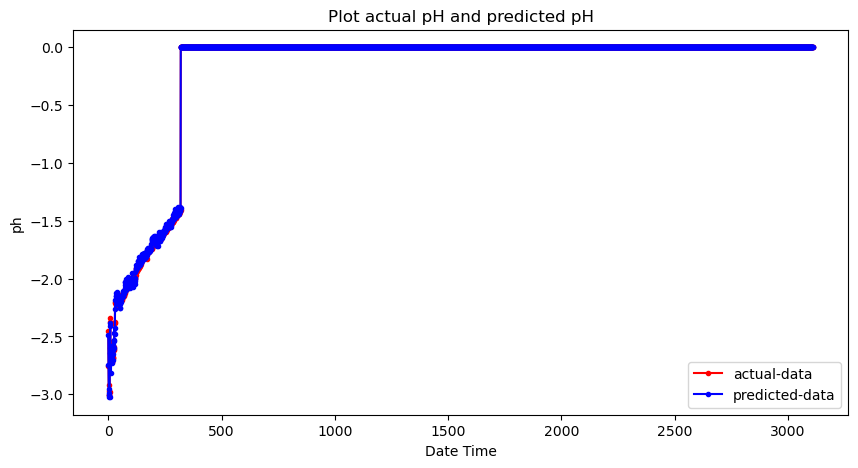

In [146]:
plt.figure(figsize=(10, 5))
index = 0
# for index in range(10):
plt.plot(y_test, marker='.', color="red", label="actual-data")
plt.plot(y_pred, marker='.', color="blue", label = "predicted-data")


plt.xlabel('Date Time')
plt.ylabel('ph')
plt.title(f'Plot actual pH and predicted pH')
plt.legend()
plt.show()